**Import the relevant libraries**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
import warnings
from collections import Counter
from sklearn.metrics import roc_curve, auc



warnings.filterwarnings('ignore')

**Load the data**

In [4]:
model_output = pd.read_excel(r'C:\Users\user\Downloads\credit_model_predictions_threshold_025.xlsx')

In [5]:
model_output.head()

,Actual,Prob_Class_0,Prob_Class_1,Predicted
0,1,0.605660,0.394340,1
1,0,0.998685,0.001315,0
2,0,0.998325,0.001675,0
3,0,0.985886,0.014114,0
4,0,0.981745,0.018255,0


In [6]:
#i sorted by probability of bad loan in descending order
output_sorted = model_output.sort_values(by="Prob_Class_1", ascending=False).reset_index(drop=True)

In [7]:
output_sorted["Decile"] = pd.qcut(output_sorted["Prob_Class_1"], 10, labels=False, duplicates='drop') + 1
output_sorted["Decile"] = output_sorted["Decile"].max() - output_sorted["Decile"] + 1  # reverse order

In [8]:
output_sorted

,Actual,Prob_Class_0,Prob_Class_1,Predicted,Decile
0,1,0.005582,0.994418,1,1
1,0,0.007148,0.992852,1,1
2,1,0.017542,0.982458,1,1
3,0,0.018061,0.981939,1,1
4,1,0.020917,0.979083,1,1
...,...,...,...,...,...
595,0,0.999885,0.000115,0,10
596,0,0.999887,0.000113,0,10
597,0,0.999898,0.000102,0,10
598,0,0.999918,0.000082,0,10


In [9]:
#group by Decile and calculate key metrics
decile_summary = output_sorted.groupby("Decile").agg(
    Total=("Actual", "count"),
    Good_Loans=("Actual", lambda x: (x == 0).sum()),
    Bad_Loans=("Actual", lambda x: (x == 1).sum())
).reset_index()

**Cumulative Metrics**

In [11]:
#cumulative metrics
decile_summary["Cumm_Good"] = decile_summary["Good_Loans"].cumsum()
decile_summary["Cumm_Bad"] = decile_summary["Bad_Loans"].cumsum()

total_good = (output_sorted["Actual"] == 0).sum()
total_bad = (output_sorted["Actual"] == 1).sum()

decile_summary["Sensitivity_CummGoodPct"] = decile_summary["Cumm_Good"] / total_good
decile_summary["Specificity_CummBadAvoidedPct"] = 1 - (decile_summary["Cumm_Bad"] / total_bad)

**Profit Calculation**

In [13]:
#profit calculation
decile_summary["Profit_to_Business"] = (decile_summary["Good_Loans"] * 100) - (decile_summary["Bad_Loans"] * 500)

In [14]:
decile_summary.head()

,Decile,Total,Good_Loans,Bad_Loans,Cumm_Good,Cumm_Bad,Sensitivity_CummGoodPct,Specificity_CummBadAvoidedPct,Profit_to_Business
0,1,60,36,24,36,24,0.072,0.76,-8400
1,2,60,34,26,70,50,0.140,0.50,-9600
2,3,60,46,14,116,64,0.232,0.36,-2400
3,4,60,46,14,162,78,0.324,0.22,-2400
4,5,60,56,4,218,82,0.436,0.18,3600


In [15]:
#save to excel
decile_summary.to_excel("decile_analysis.xlsx", index=False)

**Plot the Summary**

**Profitability by Decile**

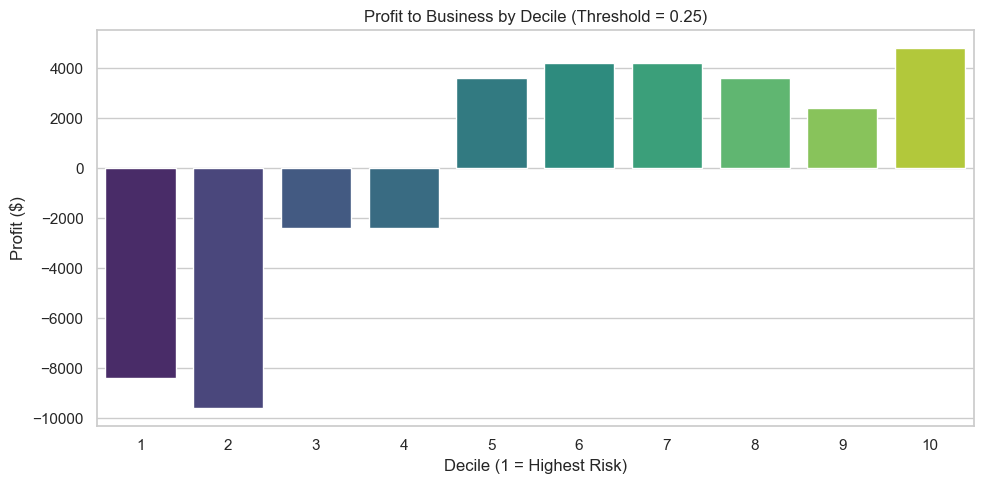

In [17]:
#profit by Decile
plt.figure(figsize=(10, 5))
sns.barplot(data=decile_summary, x="Decile", y="Profit_to_Business", palette="viridis")
plt.title("Profit to Business by Decile (Threshold = 0.25)")
plt.ylabel("Profit ($)")
plt.xlabel("Decile (1 = Highest Risk)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('profit_to_business_by_decile.png', dpi=300, bbox_inches='tight')
plt.show()

**ROC Curve**

In [19]:
#extract true values and predicted probabilities
y_true = model_output["Actual"]
y_scores = model_output["Prob_Class_1"]

In [20]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

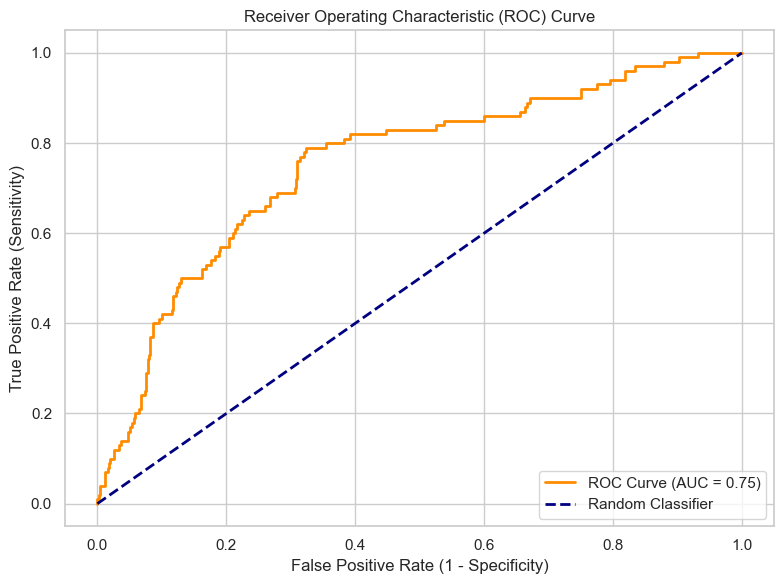

In [38]:
#plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Random Classifier")
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

**Sensitivity vs Specificity**

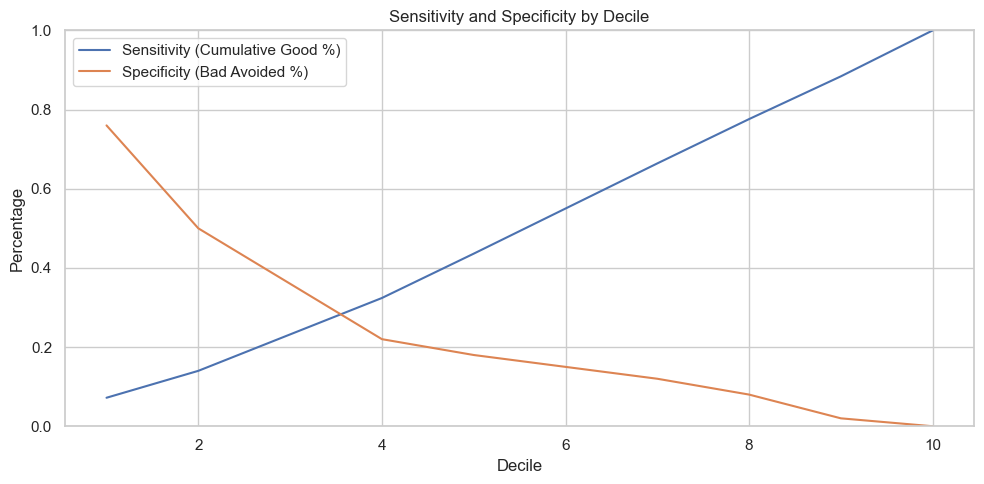

In [42]:
#sensitivity and specificity
plt.figure(figsize=(10, 5))
sns.lineplot(data=decile_summary, x="Decile", y="Sensitivity_CummGoodPct", label="Sensitivity (Cumulative Good %)")
sns.lineplot(data=decile_summary, x="Decile", y="Specificity_CummBadAvoidedPct", label="Specificity (Bad Avoided %)")
plt.title("Sensitivity and Specificity by Decile")
plt.ylabel("Percentage")
plt.xlabel("Decile")
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.savefig('sensitivity_specificity.png', dpi=300, bbox_inches='tight')
plt.show()